In [ ]:
import tensorflow as tf 
from tacotron.utils.symbols import symbols
from infolog import log
from tacotron.models.helpers import TacoTrainingHelper, TacoTestHelper
from tacotron.models.modules import *
from tensorflow.contrib.seq2seq import dynamic_decode
from tacotron.models.Architecture_wrappers import TacotronEncoderCell, TacotronDecoderCell
from tacotron.models.custom_decoder import CustomDecoder
from tacotron.models.attention import 

import numpy as np

def split_func(x, split_pos):
    rst = []
    start = 0
    # x will be a numpy array with the contents of the placeholder below
    for i in range(split_pos.shape[0]):
        rst.append(x[:,start:start+split_pos[i]])
        start += split_pos[i]
    return rst

In [ ]:
class Tacotron():
    """Tacotron-2 Feature prediction Model.
    """
    def __init__(self, hparams):
        self._hparams = hparams

    def initialize(self, inputs, input_lengths, mel_targets=None, stop_token_targets=None, linear_targets=None, targets_lengths=None, gta=False,
            global_step=None, is_training=False, is_evaluating=False, split_infos=None):
        """
        Initializes the model for inference
        sets "mel_outputs" and "alignments" fields.
        Args:
            - inputs: int32 Tensor with shape [N, T_in] where N is batch size, T_in is number of
              steps in the input time series, and values are character IDs
            - input_lengths: int32 Tensor with shape [N] where N is batch size and values are the lengths
            of each sequence in inputs.
            - mel_targets: float32 Tensor with shape [N, T_out, M] where N is batch size, T_out is number
            of steps in the output time series, M is num_mels, and values are entries in the mel
            spectrogram. Only needed for training.
        """
        if mel_targets is None and stop_token_targets is not None:
            raise ValueError('no multi targets were provided but token_targets were given')
        if mel_targets is not None and stop_token_targets is None and not gta:
            raise ValueError('Mel targets are provided without corresponding token_targets')
        if not gta and self._hparams.predict_linear==True and linear_targets is None and is_training:
            raise ValueError('Model is set to use post processing to predict linear spectrograms in training but no linear targets given!')
        if gta and linear_targets is not None:
            raise ValueError('Linear spectrogram prediction is not supported in GTA mode!')
        if is_training and self._hparams.mask_decoder and targets_lengths is None:
            raise RuntimeError('Model set to mask paddings but no targets lengths provided for the mask!')
        if is_training and is_evaluating:
            raise RuntimeError('Model can not be in training and evaluation modes at the same time!')
            
        split_device = '/cpu:0' if self._hparams.tacotron_num_gpus > 1 or self._hparams.split_on_cpu else '/gpu:0'

In [ ]:
        with tf.device(split_device):
            hp = self._hparams
            lout_int = [tf.int32]*hp.tacotron_num_gpus
            lout_float = [tf.float32]*hp.tacotron_num_gpus

            tower_input_lengths = tf.split(input_lengths, num_or_size_splits=hp.tacotron_num_gpus, axis=0)
            tower_targets_lengths = tf.split(targets_lengths, num_or_size_splits=hp.tacotron_num_gpus, axis=0) if targets_lengths is not None else targets_lengths

            p_inputs = tf.py_func(split_func, [inputs, split_infos[:, 0]], lout_int)
            p_mel_targets = tf.py_func(split_func, [mel_targets, split_infos[:,1]], lout_float) if mel_targets is not None else mel_targets
            p_stop_token_targets = tf.py_func(split_func, [stop_token_targets, split_infos[:,2]], lout_float) if stop_token_targets is not None else stop_token_targets
            p_linear_targets = tf.py_func(split_func, [linear_targets, split_infos[:,3]], lout_float) if linear_targets is not None else linear_targets

            tower_inputs = []
            tower_mel_targets = []
            tower_stop_token_targets = []
            tower_linear_targets = []

            batch_size = tf.shape(inputs)[0]
            mel_channels = hp.num_mels
            linear_channels = hp.num_freq
            for i in range (hp.tacotron_num_gpus):
                tower_inputs.append(tf.reshape(p_inputs[i], [batch_size, -1]))
                if p_mel_targets is not None:
                    tower_mel_targets.append(tf.reshape(p_mel_targets[i], [batch_size, -1, mel_channels]))
                if p_stop_token_targets is not None:
                    tower_stop_token_targets.append(tf.reshape(p_stop_token_targets[i], [batch_size, -1]))
                if p_linear_targets is not None:
                    tower_linear_targets.append(tf.reshape(p_linear_targets[i], [batch_size, -1, linear_channels]))

        T2_output_range = (-hp.max_abs_value, hp.max_abs_value) if hp.symmetric_mels else (0, hp.max_abs_value)

        self.tower_decoder_output = []
        self.tower_alignments = []
        self.tower_stop_token_prediction = []
        self.tower_mel_outputs = []
        self.tower_linear_outputs = []

        tower_embedded_inputs = []
        tower_enc_conv_output_shape = []
        tower_encoder_outputs = []
        tower_residual = []
        tower_projected_residual = []

#### tf.py_func

这是一个可以把 TensorFlow 和 Python 原生代码无缝衔接起来的函数，有了它，你就可以在 TensorFlow 里面自由的实现你想要的功能，而不用考虑 TensorFlow 有没有实现它的 API，并且可以帮助我们实现自由的检查该功能模块的输入输出是否正确，而不受到TensorFlow 的先构造计算图再运行导致的不能单独检测单一模块的功能的限制；

它的具体功能描述是**包装一个普通的 Python 函数，这个函数接受 numpy 的数组作为输入和输出，让这个函数可以作为 TensorFlow 计算图上的计算节点 OP 来使用**。

```
py_func(func, inp, Tout, stateful=True, name=None)
```

参数：

- 一个 Python 函数, 它接受 NumPy 数组作为输入和输出，并且数组的类型和大小必须和输入和输出用来衔接的 Tensor 大小和数据类型相匹配.

- inp: 输入的 Tensor 列表.

- Tout: 输出 Tensor 数据类型的列表或元祖.

- stateful: boolean

- name: 节点op的名称

**缺点：**

这个被包装过的的计算函数的内部部分不会被序列化到 GraphDef 里面去，所以，如果你要序列化存储和恢复模型，就不能使用该函数。
这个被包装的计算节点 OP 与调用它的 Python 程序必须运行在同一个物理设备上，也就是说，如果使用分布式TensorFlow，必须使用 tf.train.Server 和 with tf.device(): 来保证二者在同一个服务器内。

```
import tensorflow as tf

def add(x,y):
     return x+y,x-y,x.dot(y)

a = [[1,2],[3,4]]
b = [[1,2],[1,1]]
x = tf.placeholder(tf.float32,(2,2))
y = tf.placeholder(tf.float32,(2,2))
result1,result2,result3 = tf.py_func(add, [x,y], [tf.float32,tf.float32,tf.float32])

with tf.Session as sess:
    sess.run(tf.global_varbles_initializer())
    s1,s2,s3 = sess.run([result1,result2,result3],feed_dict = {x:a,y:b})
    print(s1,s2,s3)
```

### Character Embedding

In [ ]:
        # 1. Declare GPU Devices
        gpus = [f"/gpu:{i}" for i in range(hp.tacotron_num_gpus)]
        for i in range(hp.tacotron_num_gpus):
            with tf.device(tf.train.replica_device_setter(ps_tasks=1, ps_device="/cpu:0", worker_device=gpus[i])):
                with tf.variable_scope('inference') as scope:
                    assert hp.tacotron_teacher_forcing_mode in ('constant', 'scheduled')
                    if hp.tacotron_teacher_forcing_mode == 'scheduled' and is_training:
                        assert global_step is not None

                    #GTA is only used for predicting mels to train Wavenet vocoder, so we ommit post processing when doing GTA synthesis
                    post_condition = hp.predict_linear and not gta

                    # Embeddings ==> [batch_size, sequence_length, embedding_dim]
                    self.embedding_table = tf.get_variable('inputs_embedding', [len(symbols), hp.embedding_dim], dtype=tf.float32)
                    embedded_inputs = tf.nn.embedding_lookup(self.embedding_table, tower_inputs[i])

### Encoder Block

Encoder部分是由TacotronEncoderCell类表示的，里面包含了EncoderConvolutions卷积和 EncoderRNN(lstm)循环网络，TacotronEncoderCell在`./Architecture_wrapper.ipynb`中。EncoderConvolutions和EncoderRNN在`./modules.ipynb`

具体内容看 ：

- `./Architecture_wrappers.ipynb` http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/Architecture_wrappers.ipynb

-  `./modules.ipynb` http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/modules.ipynb

Passes inputs through a stack of convolutional layers (3 layers, kernel_size=5, channel=512, dropout_rate=0.5, relu,在激活函数之后用batch_norm) then through a bidirectional LSTM layer(zoneout instead of dropout) to predict the hidden representation vector

In [ ]:
                    #Encoder Cell ==> [batch_size, encoder_steps, encoder_lstm_units]
                    encoder_cell = TacotronEncoderCell(
                        EncoderConvolutions(is_training, hparams=hp, scope='encoder_convolutions'),
                        EncoderRNN(is_training, size=hp.encoder_lstm_units,
                            zoneout=hp.tacotron_zoneout_rate, scope='encoder_LSTM'))

                    encoder_outputs = encoder_cell(embedded_inputs, tower_input_lengths[i])
                    
                    #For shape visualization purpose
                    enc_conv_output_shape = encoder_cell.conv_output_shape

对内部类进行详细介绍。Tacotron2中conv_layer给予了neural net类似于n-gram感知上下文的能力，主要是由于RNN很难捕获长时依赖，并且conv-layer使得模型对不发音字符更具有鲁棒性。

In [ ]:
class EncoderConvolutions:
    """Encoder convolutional layers used to find local dependencies in inputs characters.
    """
    def __init__(self, is_training, hparams, activation=tf.nn.relu, scope=None):
        """
        Args:
            is_training: Boolean, determines if the model is training or in inference to control dropout
            kernel_size: tuple or integer, The size of convolution kernels
            channels: integer, number of convolutional kernels
            activation: callable, postnet activation function for each convolutional layer
            scope: Postnet scope.
        """
        super(EncoderConvolutions, self).__init__()
        self.is_training = is_training

        self.kernel_size = hparams.enc_conv_kernel_size
        self.channels = hparams.enc_conv_channels
        self.activation = activation
        self.scope = 'enc_conv_layers' if scope is None else scope
        self.drop_rate = hparams.tacotron_dropout_rate
        self.enc_conv_num_layers = hparams.enc_conv_num_layers
        self.bnorm = hparams.batch_norm_position
        
    def __call__(self, inputs):
        with tf.variable_scope(self.scope):
            x = inputs
            for i in range(self.enc_conv_num_layers):
                x = conv1d(x, self.kernel_size, self.channels, self.activation,
                    self.is_training, self.drop_rate, self.bnorm, 'conv_layer_{}_'.format(i + 1)+self.scope)
        return x        

In [ ]:
class EncoderRNN:
    """Encoder bidirectional one layer LSTM
    """
    def __init__(self, is_training, size=256, zoneout=0.1, scope=None):
        """
        Args:
            is_training: Boolean, determines if the model is training or in inference to control zoneout
            size: integer, the number of LSTM units for each direction
            zoneout: the zoneout factor
            scope: EncoderRNN scope.
        """
        super(EncoderRNN, self).__init__()
        self.is_training = is_training

        self.size = size
        self.zoneout = zoneout
        self.scope = 'encoder_LSTM' if scope is None else scope

        #Create forward LSTM Cell
        self._fw_cell = ZoneoutLSTMCell(size, is_training,
            zoneout_factor_cell=zoneout,
            zoneout_factor_output=zoneout,
            name='encoder_fw_LSTM') #前向RNN

        #Create backward LSTM Cell
        self._bw_cell = ZoneoutLSTMCell(size, is_training,
            zoneout_factor_cell=zoneout,
            zoneout_factor_output=zoneout,
            name='encoder_bw_LSTM') #后向RNN

    def __call__(self, inputs, input_lengths):
        with tf.variable_scope(self.scope):
            outputs, (fw_state, bw_state) = tf.nn.bidirectional_dynamic_rnn(
                self._fw_cell,
                self._bw_cell,
                inputs,
                sequence_length=input_lengths,
                dtype=tf.float32,
                swap_memory=True) #sequence_length:输入序列的实际长度（可选，默认为最大长度）
            #用bidirectional-RNN是为了确保模型能够同时感知前向和后向的信息
            return tf.concat(outputs, axis=2) # Concat and return forward + backward outputs

其中**ZoneoutLSTM**: A method for regularizing RNN. At each steps, zoneout stochastically forces some hidden units to maintain their previous values. Zoneout uses random noises to train a pseudo-ensemble, improving generalization. By preserving instead of dropping hidden units, gradient information and state information are more readily propagated through time, as in feedforward stochastic depth networks.
LSTM is defined as follow:
$$i_t,f_t,o_t=\sigma(W_xx_t+W_th_{h-1}+b)$$

$$g_t=tanh(W_{xg} x_t+W_{hg}h_{t-1}+b_g)$$

$$c_t=f_t \odot c_{t-1}+i_t \odot g_t$$

$$h_t=o_t \odot tanh(c_t)$$

In [ ]:
class ZoneoutLSTMCell(tf.nn.rnn_cell.RNNCell):
    '''Wrapper for tf LSTM to create Zoneout LSTM Cell
    inspired by:
    https://github.com/teganmaharaj/zoneout/blob/master/zoneout_tensorflow.py
    Published by one of 'https://arxiv.org/pdf/1606.01305.pdf' paper writers.
    Many thanks to @Ondal90 for pointing this out. You sir are a hero!
    '''
    def __init__(self, num_units, is_training, zoneout_factor_cell=0., zoneout_factor_output=0., state_is_tuple=True, name=None):
        '''Initializer with possibility to set different zoneout values for cell/hidden states.
        '''
        zm = min(zoneout_factor_output, zoneout_factor_cell)
        zs = max(zoneout_factor_output, zoneout_factor_cell)

        if zm < 0. or zs > 1.:
            raise ValueError('One/both provided Zoneout factors are not in [0, 1]')

        self._cell = tf.nn.rnn_cell.LSTMCell(num_units, state_is_tuple=state_is_tuple, name=name)
        self._zoneout_cell = zoneout_factor_cell
        self._zoneout_outputs = zoneout_factor_output
        self.is_training = is_training
        self.state_is_tuple = state_is_tuple

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return self._cell.output_size

    def __call__(self, inputs, state, scope=None):
        '''Runs vanilla LSTM Cell and applies zoneout.
        '''
        #Apply vanilla LSTM
        output, new_state = self._cell(inputs, state, scope)

        if self.state_is_tuple:
            (prev_c, prev_h) = state
            (new_c, new_h) = new_state
        else:
            num_proj = self._cell._num_units if self._cell._num_proj is None else self._cell._num_proj
            prev_c = tf.slice(state, [0, 0], [-1, self._cell._num_units])
            prev_h = tf.slice(state, [0, self._cell._num_units], [-1, num_proj])
            new_c = tf.slice(new_state, [0, 0], [-1, self._cell._num_units])
            new_h = tf.slice(new_state, [0, self._cell._num_units], [-1, num_proj])

        #Apply zoneout
        if self.is_training:
            #nn.dropout takes keep_prob (probability to keep activations) not drop_prob (probability to mask activations)!
            c = (1 - self._zoneout_cell) * tf.nn.dropout(new_c - prev_c, (1 - self._zoneout_cell)) + prev_c
            h = (1 - self._zoneout_outputs) * tf.nn.dropout(new_h - prev_h, (1 - self._zoneout_outputs)) + prev_h

        else:
            c = (1 - self._zoneout_cell) * new_c + self._zoneout_cell * prev_c
            h = (1 - self._zoneout_outputs) * new_h + self._zoneout_outputs * prev_h

        new_state = tf.nn.rnn_cell.LSTMStateTuple(c, h) if self.state_is_tuple else tf.concat(1, [c, h])

        return output, new_state

zoneoutLSTM is defined as follow:

$$c_t=d_t^c\odot c_{t-1}+(1-d^c_t)\odot (f_t \odot c_{t-1}+i_t \odot g_t)$$

$$h_t=d_t^h\odot h_{t-1}+(1-d^h_t)\odot (o_t \odot tanh(c_t))$$

Now we get encoder features（context vector）

### Decoder Block

Tacotron2的Decoder部分是由以下五部分构成：

1. Prenet ： 2层Fc全连接

2. LocationSensitiveAttention

3. LSTM：两层ZoneOutLSTM组成

4. FrameProjection: 1层Dense , no activation, 为了调整输出维度

5. StopProjection : 1层Dense, activation = sigmoid

decoder是一个自回归RNN，它从encoder的输入序列预测输出声谱图，一次预测一帧。

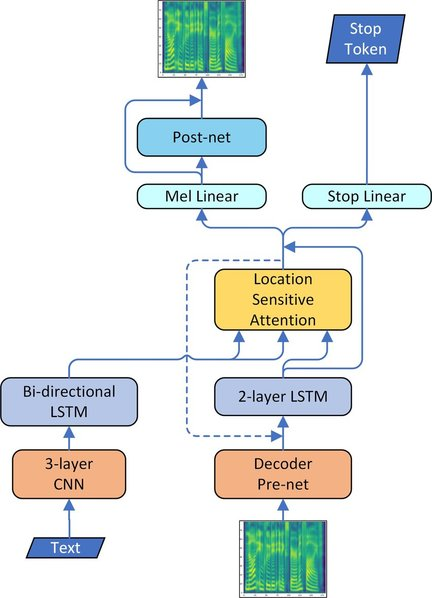

In [ ]:
                    #Decoder Parts
                    #Attention Decoder Prenet
                    prenet = Prenet(is_training, layers_sizes=hp.prenet_layers, drop_rate=hp.tacotron_dropout_rate, scope='decoder_prenet')
                    
                    #Attention Mechanism
                    attention_mechanism = LocationSensitiveAttention(hp.attention_dim, encoder_outputs, hparams=hp, is_training=is_training,
                        mask_encoder=hp.mask_encoder, memory_sequence_length=tf.reshape(tower_input_lengths[i], [-1]), smoothing=hp.smoothing,
                        cumulate_weights=hp.cumulative_weights)
                    
                    #Decoder LSTM Cells
                    decoder_lstm = DecoderRNN(is_training, layers=hp.decoder_layers,
                        size=hp.decoder_lstm_units, zoneout=hp.tacotron_zoneout_rate, scope='decoder_LSTM')
                    
                    #Frames Projection layer
                    frame_projection = FrameProjection(hp.num_mels * hp.outputs_per_step, scope='linear_transform_projection')
                    
                    #<stop_token> projection layer
                    stop_projection = StopProjection(is_training or is_evaluating, shape=hp.outputs_per_step, scope='stop_token_projection')


                    #Decoder Cell ==> [batch_size, decoder_steps, num_mels * r] (after decoding)
                    decoder_cell = TacotronDecoderCell(
                        prenet,
                        attention_mechanism,
                        decoder_lstm,
                        frame_projection,
                        stop_projection)

接下来具体介绍每一类代码

In [ ]:
class Prenet:
    """Two fully connected layers used as an information bottleneck for the attention.
    """
    def __init__(self, is_training, layers_sizes=[256, 256], drop_rate=0.5, activation=tf.nn.relu, scope=None):
        """
        Args:
            layers_sizes: list of integers, the length of the list represents the number of pre-net
                layers and the list values represent the layers number of units
            activation: callable, activation functions of the prenet layers.
            scope: Prenet scope.
        """
        super(Prenet, self).__init__()
        self.drop_rate = drop_rate

        self.layers_sizes = layers_sizes
        self.activation = activation
        self.is_training = is_training

        self.scope = 'prenet' if scope is None else scope

    def __call__(self, inputs):
        x = inputs

        with tf.variable_scope(self.scope):
            for i, size in enumerate(self.layers_sizes):
                dense = tf.layers.dense(x, units=size, activation=self.activation,
                    name='dense_{}'.format(i + 1))
                #The paper discussed introducing diversity in generation at inference time
                #by using a dropout of 0.5 only in prenet layers (in both training and inference).
                x = tf.layers.dropout(dense, rate=self.drop_rate, training=True,
                    name='dropout_{}'.format(i + 1) + self.scope)
        return x

attention mechanism用作encoder-decoder的桥梁，本质上是一个上下文权重向量组成的矩阵

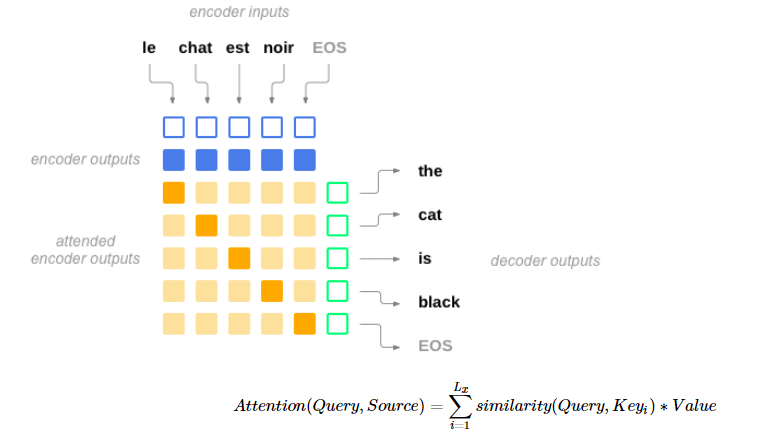

在tacotron2中，attention computation 发生在每一个解码器时间步上，其中包含一下阶段：

1.目标隐函数(上图绿框所示)与每一个源状态(上图蓝框所示)"相比"，以生成attention weights(注意力权重)或alignments(对齐)

$$\alpha_{ts}=\frac{exp(score(h_t,\bar{h_s}))}{\sum_{s'=1}^{S}exp(score(h_t,\bar{h_s'}))}$$

其中$h_t$为目标隐状态，$\hat{h_s}$为源状态，score函数常被称为“能量(energy)”,因此可以表示为$e$.不同的score函数决定了不同类型的attention mechanism. Tacotron2 中使用的是 Location Sensitive Attention

$$e_{ij}=score(s_{i},c\alpha_{i-1},h_j)=v_a^Ttanh(W{s_{i}}+Vh_j+Uf_{i,j}+b)$$

其中$s_i$为当前解码器的输出(解码器隐状态 decoder hidden states), $h_j$是第j个编码器此刻输出(编码器隐状态 encoder hidden state),位置特征$f_{i,j}$使用累加是attention weight $c \alpha_i$经卷积而得的位置特征

$$f_i=F*c\alpha_{i-1},c\alpha_i=\sum_{j=1}^{i-1}\alpha_j$$

之所以使用加法累加而非乘法累积原因如图：

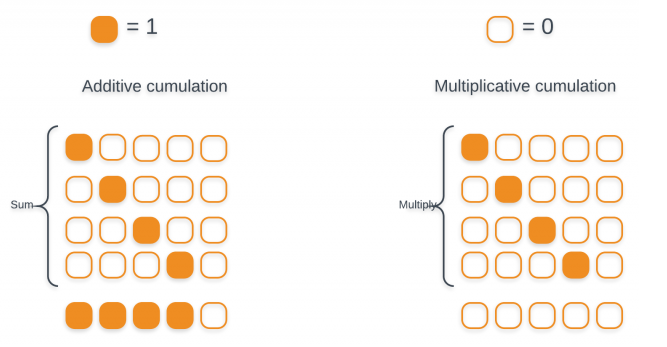

累加注意力权重可以使得注意力权重网络了解它已经学习到的注意力信息，使得模型能在序列中持续进行并且避免重复未预料的语音。

使用注意力机制如图：

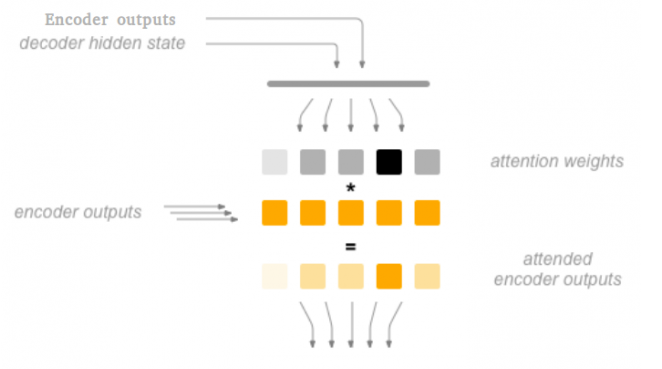

In [ ]:
class LocationSensitiveAttention(BahdanauAttention):
    """Impelements Bahdanau-style (cumulative) scoring function.
    Usually referred to as "hybrid" attention (content-based + location-based)
    Extends the additive attention described in:
    "D. Bahdanau, K. Cho, and Y. Bengio, “Neural machine transla
    tion by jointly learning to align and translate,” in Proceedings
    of ICLR, 2015."
    to use previous alignments as additional location features.
    This attention is described in:
    J. K. Chorowski, D. Bahdanau, D. Serdyuk, K. Cho, and Y. Ben-
  gio, “Attention-based models for speech recognition,” in Ad-
  vances in Neural Information Processing Systems, 2015, pp.
  577–585.
    """

    def __init__(self,num_units,memory,hparams,is_training,mask_encoder=True,memory_sequence_length=None,
                 smoothing=False,cumulate_weights=True,name='LocationSensitiveAttention'):
        """Construct the Attention mechanism.
        Args:
            num_units: The depth of the query mechanism.
            memory: The memory to query; usually the output of an RNN encoder.  This
                tensor should be shaped `[batch_size, max_time, ...]`.
            mask_encoder (optional): Boolean, whether to mask encoder paddings.
            memory_sequence_length (optional): Sequence lengths for the batch entries
                in memory.  If provided, the memory tensor rows are masked with zeros
                for values past the respective sequence lengths. Only relevant if mask_encoder = True.
            smoothing (optional): Boolean. Determines which normalization function to use.
                Default normalization function (probablity_fn) is softmax. If smoothing is
                enabled, we replace softmax with:
                        a_{i, j} = sigmoid(e_{i, j}) / sum_j(sigmoid(e_{i, j}))
                Introduced in:
                    J. K. Chorowski, D. Bahdanau, D. Serdyuk, K. Cho, and Y. Ben-
                     gio, “Attention-based models for speech recognition,” in Ad-
                     vances in Neural Information Processing Systems, 2015, pp.
                     577–585.
                This is mainly used if the model wants to attend to multiple input parts
                at the same decoding step. We probably won't be using it since multiple sound
                frames may depend on the same character/phone, probably not the way around.
                Note:
                    We still keep it implemented in case we want to test it. They used it in the
                    paper in the context of speech recognition, where one phoneme may depend on
                    multiple subsequent sound frames.
            name: Name to use when creating ops.
        """
        #Create normalization function
        #Setting it to None defaults in using softmax
        normalization_function = _smoothing_normalization if (smoothing == True) else None
        memory_length = memory_sequence_length if (mask_encoder==True) else None
        super(LocationSensitiveAttention, self).__init__(num_units=num_units,memory=memory,
              memory_sequence_length=memory_length,probability_fn=normalization_function,
              name=name)

        self.location_convolution = tf.layers.Conv1D(filters=hparams.attention_filters,
            kernel_size=hparams.attention_kernel, padding='same', use_bias=True,
            bias_initializer=tf.zeros_initializer(), name='location_features_convolution')
        self.location_layer = tf.layers.Dense(units=num_units, use_bias=False,
            dtype=tf.float32, name='location_features_layer')
        self._cumulate = cumulate_weights
        self.synthesis_constraint = hparams.synthesis_constraint and not is_training
        self.attention_win_size = tf.convert_to_tensor(hparams.attention_win_size, dtype=tf.int32)
        self.constraint_type = hparams.synthesis_constraint_type

    def __call__(self, query, state, prev_max_attentions):
        """Score the query based on the keys and values.
        Args:
            query: Tensor of dtype matching `self.values` and shape
                `[batch_size, query_depth]`.
            state (previous alignments): Tensor of dtype matching `self.values` and shape
                `[batch_size, alignments_size]`
                (`alignments_size` is memory's `max_time`).
        Returns:
            alignments: Tensor of dtype matching `self.values` and shape
                `[batch_size, alignments_size]` (`alignments_size` is memory's
                `max_time`).
        """
        previous_alignments = state
        with variable_scope.variable_scope(None, "Location_Sensitive_Attention", [query]):

            # processed_query shape [batch_size, query_depth] -> [batch_size, attention_dim]
            processed_query = self.query_layer(query) if self.query_layer else query
            # -> [batch_size, 1, attention_dim]
            processed_query = tf.expand_dims(processed_query, 1)

            # processed_location_features shape [batch_size, max_time, attention dimension]
            # [batch_size, max_time] -> [batch_size, max_time, 1]
            expanded_alignments = tf.expand_dims(previous_alignments, axis=2)
            # location features [batch_size, max_time, filters]
            f = self.location_convolution(expanded_alignments)
            # Projected location features [batch_size, max_time, attention_dim]
            processed_location_features = self.location_layer(f)

            # energy shape [batch_size, max_time]
            energy = _location_sensitive_score(processed_query, processed_location_features, self.keys)

        if self.synthesis_constraint:
            Tx = tf.shape(energy)[-1]
            # prev_max_attentions = tf.squeeze(prev_max_attentions, [-1])
            if self.constraint_type == 'monotonic':
                key_masks = tf.sequence_mask(prev_max_attentions, Tx)
                reverse_masks = tf.sequence_mask(Tx - self.attention_win_size - prev_max_attentions, Tx)[:, ::-1]
            else:
                assert self.constraint_type == 'window'
                key_masks = tf.sequence_mask(prev_max_attentions - (self.attention_win_size // 2 + (self.attention_win_size % 2 != 0)), Tx)
                reverse_masks = tf.sequence_mask(Tx - (self.attention_win_size // 2) - prev_max_attentions, Tx)[:, ::-1]
            
            masks = tf.logical_or(key_masks, reverse_masks)
            paddings = tf.ones_like(energy) * (-2 ** 32 + 1)  # (N, Ty/r, Tx)
            energy = tf.where(tf.equal(masks, False), energy, paddings)

        # alignments shape = energy shape = [batch_size, max_time]
        alignments = self._probability_fn(energy, previous_alignments)
        max_attentions = tf.argmax(alignments, -1, output_type=tf.int32) # (N, Ty/r)

        # Cumulate alignments
        if self._cumulate:
            next_state = alignments + previous_alignments
        else:
            next_state = alignments

        return alignments, next_state, max_attentions

In [ ]:
def _smoothing_normalization(e):
    """Applies a smoothing normalization function instead of softmax

                        Smoothing normalization function
                a_{i, j} = sigmoid(e_{i, j}) / sum_j(sigmoid(e_{i, j}))

    Args:
        e: matrix [batch_size, max_time(memory_time)]: expected to be energy (score)
            values of an attention mechanism
    Returns:
        matrix [batch_size, max_time]: [0, 1] normalized alignments with possible
            attendance to multiple memory time steps.
    """
    return tf.nn.sigmoid(e) / tf.reduce_sum(tf.nn.sigmoid(e), axis=-1, keepdims=True)

In [ ]:
def _location_sensitive_score(W_query, W_fil, W_keys):
    """
              hybrid attention (content-based + location-based)
                               f = F * α_{i-1}
          energy = dot(v_a, tanh(W_keys(h_enc) + W_query(h_dec) + W_fil(f) + b_a))

    Args:
        W_query: Tensor, shape '[batch_size, 1, attention_dim]' to compare to location features.
        W_location: processed previous alignments into location features, shape '[batch_size, max_time, attention_dim]'
        W_keys: Tensor, shape '[batch_size, max_time, attention_dim]', typically the encoder outputs.
    Returns:
        A '[batch_size, max_time]' attention score (energy) #e_ij
    """
    # Get the number of hidden units from the trailing dimension of keys
    dtype = W_query.dtype
    num_units = W_keys.shape[-1].value or array_ops.shape(W_keys)[-1]

    v_a = tf.get_variable(
        'attention_variable_projection', shape=[num_units], dtype=dtype,
        initializer=tf.contrib.layers.xavier_initializer())
    b_a = tf.get_variable(
        'attention_bias', shape=[num_units], dtype=dtype,
        initializer=tf.zeros_initializer())

    return tf.reduce_sum(v_a * tf.tanh(W_keys + W_query + W_fil + b_a), [2])

$e_{ij}=score(s_{i},c\alpha_{i-1},h_j)=v_a^Ttanh(W{s_{i}}+Vh_j+Uf_{i,j}+b)$

W_keys:$V$ 对应encoder_hidden state

W_query:$W$ 对应decoder_hidden state

W_fil: $f_i=F*c\alpha_{i-1},c\alpha_i=\sum_{j=1}^{i-1}\alpha_j$

In [ ]:
class DecoderRNN:
    """Decoder two uni directional LSTM Cells
    """
    def __init__(self, is_training, layers=2, size=1024, zoneout=0.1, scope=None):
        """
        Args:
            is_training: Boolean, determines if the model is in training or inference to control zoneout
            layers: integer, the number of LSTM layers in the decoder
            size: integer, the number of LSTM units in each layer
            zoneout: the zoneout factor
        """
        super(DecoderRNN, self).__init__()
        self.is_training = is_training

        self.layers = layers
        self.size = size
        self.zoneout = zoneout
        self.scope = 'decoder_rnn' if scope is None else scope

        #Create a set of LSTM layers
        self.rnn_layers = [ZoneoutLSTMCell(size, is_training,zoneout_factor_cell=zoneout,zoneout_factor_output=zoneout,
                           name='decoder_LSTM_{}'.format(i+1)) for i in range(layers)]

        self._cell = tf.contrib.rnn.MultiRNNCell(self.rnn_layers, state_is_tuple=True)

    def __call__(self, inputs, states):
        with tf.variable_scope(self.scope):
            return self._cell(inputs, states)

### ZoneoutLSTM

https://arxiv.org/abs/1606.01305
它不是单独的cell,而是指训练时的一个trick.

A novel method for regularizing RNNs. At each timestep, zoneout stochastically forces some hidden units to maintain their previous values. Like dropout, zoneout uses random noise to train a pseudo-ensemble(伪集成), improving generalization. 它使用随机"identity-masking"而不是"zero-masking"来注入噪声。我们推测identity-masking更适合RNN,因为它使网络更容易保留前一个时刻的信息，并且有助于而不是阻碍梯度信息向后流动 But by preserving instead of dropping hidden units, gradient information and state information are more readily propagated(更容易传播) through time, as in feedforward stochastic depth networks. 

In [1]:
class FrameProjection:
    """Projection layer to r * num_mels dimensions or num_mels dimensions
    """
    def __init__(self, shape=80, activation=None, scope=None):
        """
        Args:
            shape: integer, dimensionality of output space (r*n_mels for decoder or n_mels for postnet)
            activation: callable, activation function
            scope: FrameProjection scope.
        """
        super(FrameProjection, self).__init__()

        self.shape = shape
        self.activation = activation

        self.scope = 'Linear_projection' if scope is None else scope
        self.dense = tf.layers.Dense(units=shape, activation=activation, name='projection_{}'.format(self.scope))

    def __call__(self, inputs):
        with tf.variable_scope(self.scope):
            #If activation==None, this returns a simple Linear projection
            #else the projection will be passed through an activation function
            # output = tf.layers.dense(inputs, units=self.shape, activation=self.activation,
            # 	name='projection_{}'.format(self.scope))
            output = self.dense(inputs)

            return output

In [ ]:
class StopProjection:
    """Projection to a scalar and through a sigmoid activation
    """
    def __init__(self, is_training, shape=1, activation=tf.nn.sigmoid, scope=None):
        """
        Args:
            is_training: Boolean, to control the use of sigmoid function as it is useless to use it
                during training since it is integrate inside the sigmoid_crossentropy loss
            shape: integer, dimensionality of output space. Defaults to 1 (scalar)
            activation: callable, activation function. only used during inference
            scope: StopProjection scope.
        """
        super(StopProjection, self).__init__()
        self.is_training = is_training

        self.shape = shape
        self.activation = activation
        self.scope = 'stop_token_projection' if scope is None else scope

    def __call__(self, inputs):
        with tf.variable_scope(self.scope):
            output = tf.layers.dense(inputs, units=self.shape,
                activation=None, name='projection_{}'.format(self.scope))

            #During training, don't use activation as it is integrated inside the sigmoid_cross_entropy loss function
            if self.is_training:
                return output
            return self.activation(output)

In [ ]:
class TacotronDecoderCell(RNNCell):
    """Tactron 2 Decoder Cell
    Decodes encoder output and previous mel frames into next r frames
    Decoder Step i:
        1) Prenet to compress last output information
        2) Concat compressed inputs with previous context vector (input feeding) *
        3) Decoder RNN (actual decoding) to predict current state s_{i} *
        4) Compute new context vector c_{i} based on s_{i} and a cumulative sum of previous alignments *
        5) Predict new output y_{i} using s_{i} and c_{i} (concatenated)
        6) Predict <stop_token> output ys_{i} using s_{i} and c_{i} (concatenated)
    * : This is typically taking a vanilla LSTM, wrapping it using tensorflow's attention wrapper,
    and wrap that with the prenet before doing an input feeding, and with the prediction layer
    that uses RNN states to project on output space. Actions marked with (*) can be replaced with
    tensorflow's attention wrapper call if it was using cumulative alignments instead of previous alignments only.
    """

    def __init__(self, prenet, attention_mechanism, rnn_cell, frame_projection, stop_projection):
        """Initialize decoder parameters
        Args:
            prenet: A tensorflow fully connected layer acting as the decoder pre-net
            attention_mechanism: A _BaseAttentionMechanism instance, usefull to
                learn encoder-decoder alignments
            rnn_cell: Instance of RNNCell, main body of the decoder
            frame_projection: tensorflow fully connected layer with r * num_mels output units
            stop_projection: tensorflow fully connected layer, expected to project to a scalar
                and through a sigmoid activation
            mask_finished: Boolean, Whether to mask decoder frames after the <stop_token>
        """
        super(TacotronDecoderCell, self).__init__()
        #Initialize decoder layers
        self._prenet = prenet
        self._attention_mechanism = attention_mechanism
        self._cell = rnn_cell
        self._frame_projection = frame_projection
        self._stop_projection = stop_projection

        self._attention_layer_size = self._attention_mechanism.values.get_shape()[-1].value

    def _batch_size_checks(self, batch_size, error_message):
        return [check_ops.assert_equal(batch_size,self._attention_mechanism.batch_size,message=error_message)]

    @property
    def output_size(self):
        return self._frame_projection.shape

    @property
    def state_size(self):
        """The `state_size` property of `TacotronDecoderCell`.
        Returns:
          An `TacotronDecoderCell` tuple containing shapes used by this object.
        """
        return TacotronDecoderCellState(
            cell_state=self._cell._cell.state_size,
            time=tensor_shape.TensorShape([]),
            attention=self._attention_layer_size,
            alignments=self._attention_mechanism.alignments_size,
            alignment_history=(),
            max_attentions=())

    def zero_state(self, batch_size, dtype):
        """Return an initial (zero) state tuple for this `AttentionWrapper`.
		Args:
		  batch_size: `0D` integer tensor: the batch size.
		  dtype: The internal state data type.
		Returns:
		  An `TacotronDecoderCellState` tuple containing zeroed out tensors and,
		  possibly, empty `TensorArray` objects.
		Raises:
		  ValueError: (or, possibly at runtime, InvalidArgument), if
			`batch_size` does not match the output size of the encoder passed
			to the wrapper object at initialization time.
		"""
		with ops.name_scope(type(self).__name__ + "ZeroState", values=[batch_size]):
			cell_state = self._cell._cell.zero_state(batch_size, dtype)
			error_message = (
				"When calling zero_state of TacotronDecoderCell %s: " % self._base_name +
				"Non-matching batch sizes between the memory "
				"(encoder output) and the requested batch size.")
			with ops.control_dependencies(
				self._batch_size_checks(batch_size, error_message)):
				cell_state = nest.map_structure(
					lambda s: array_ops.identity(s, name="checked_cell_state"),
					cell_state)
			return TacotronDecoderCellState(
				cell_state=cell_state,
				time=array_ops.zeros([], dtype=tf.int32),
				attention=_zero_state_tensors(self._attention_layer_size, batch_size,
				  dtype),
				alignments=self._attention_mechanism.initial_alignments(batch_size, dtype),
				alignment_history=tensor_array_ops.TensorArray(dtype=dtype, size=0,
				dynamic_size=True),
				max_attentions=tf.zeros((batch_size, ), dtype=tf.int32))

	def __call__(self, inputs, state):
		#Information bottleneck (essential for learning attention)
		prenet_output = self._prenet(inputs)

		#Concat context vector and prenet output to form LSTM cells input (input feeding)
		LSTM_input = tf.concat([prenet_output, state.attention], axis=-1)

		#Unidirectional LSTM layers
		LSTM_output, next_cell_state = self._cell(LSTM_input, state.cell_state)


		#Compute the attention (context) vector and alignments using
		#the new decoder cell hidden state as query vector
		#and cumulative alignments to extract location features
		#The choice of the new cell hidden state (s_{i}) of the last
		#decoder RNN Cell is based on Luong et Al. (2015):
		#https://arxiv.org/pdf/1508.04025.pdf
		previous_alignments = state.alignments
		previous_alignment_history = state.alignment_history
		context_vector, alignments, cumulated_alignments, max_attentions = _compute_attention(self._attention_mechanism,
			LSTM_output,
			previous_alignments,
			attention_layer=None,
			prev_max_attentions=state.max_attentions)

		#Concat LSTM outputs and context vector to form projections inputs
		projections_input = tf.concat([LSTM_output, context_vector], axis=-1)

		#Compute predicted frames and predicted <stop_token>
		cell_outputs = self._frame_projection(projections_input)
		stop_tokens = self._stop_projection(projections_input)

		#Save alignment history
		alignment_history = previous_alignment_history.write(state.time, alignments)

		#Prepare next decoder state
		next_state = TacotronDecoderCellState(
			time=state.time + 1,
			cell_state=next_cell_state,
			attention=context_vector,
			alignments=cumulated_alignments,
			alignment_history=alignment_history,
			max_attentions=max_attentions)

		return (cell_outputs, stop_tokens), next_state